##  StabilityPartOnly: <br>
- version: 1_3 <br>
This code constructs the stability matrix, which can then be used to construct the initial condition for the Kawahara in form of $u(x,t)=u^{(0)}(x) + \delta e^{\lambda t} u^{(1)}(x) + O(\delta ^2)$
<br>
<br>
- version summary :
- Stability matrix bugs fixed and tested
- kawaharaStabFuncPosTest (the function that constructs stability matrix) includes two methods to calculates stability matrix
- Documented
- Includes testing for $u^{(0)}$ by plotting the bifurcation branch
<br>


In [45]:
from math import *
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
%matplotlib inline


## Function: kawaharainitial <br>
The following function Kawaharainitial solves the steady state equation
 $    Vu^{(0)}_x+\alpha u^{(0)}_{3x} +\beta u^{(0)}_{5x} + \sigma ((u^{(0)})^2)_x=0.$
 <br>
### Input parameters: <br>
- $U$ is a vector cotaining the unknown N+1 Fourier coefficients and the speed 
- a1 is the $a_1$ Fourier coefficient in the definition of $ u^{(0)}$, we use this as a free parameter representative of amplitude
- alpha, beta, sigma: $\alpha$,$\beta$,$\sigma$ in the Kawahara
- Nmodes number of Fourier modes used
### Output <br>
A vector of N+2 equations, one for every unknown <br>
<br>

Example use: <br>
Coefficients= kawaharainitial(np.array([0,1,1/2]), 0.5, alpha, beta, sigma, 1)

In [46]:
def kawaharainitial(U, a1, alpha, beta, sigma, N): #defining the equation
    kawaharaCosEqnsPos=np.zeros(N+2,dtype='float64') #first set all the equations equal to 0=0
    
    
    V=U[0] #Vector U contains the unknown coefficients and the unknown speed, we have N+2 unknowns
    a=U[1::]
    
    ### for the coefficients ###
    
    for k in range(N+1):
        sum1=0.#set the sums for the nonlinear term equal to 0 when solving for every coefficient
        sum2=0.
        for n in range(k,N+1):
            sum1=sum1+a[n]*a[n-k] 
        for n in range(0,k):
            sum2=sum2+a[n]*a[k-n] 
        kawaharaCosEqnsPos[k]=((V*a[k] + 1./2.*sigma*sum1 + 1./2.*sigma*sum2 - alpha*k**2*a[k] + beta*k**4*a[k]))
        
        
    kawaharaCosEqnsPos[N+1]=-a1+a[1] #for the last equation, linearize to optain an equation for speed
    return kawaharaCosEqnsPos
            

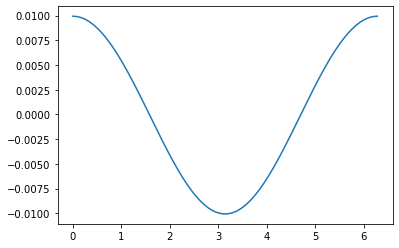

In [124]:
###### here is the stability computation all in one area ######
###############################################################

# declaring some constants
thirdAlpha = 1.
fifthBeta =1/4
nonlinSigma = 1.
c = thirdAlpha - fifthBeta
L = (np.pi)*2
spacex = np.linspace(0,L,501)
conSteps =1500 # number of continuation steps
a1=1.0e-6 # beginning amplitude
aF=1.0e-2 # ending amplitude
aS = np.linspace(a1,aF,conSteps) # vector of free parameter a1 (amplitudes)
velocities=np.zeros(conSteps) # Tracks all the velocities for bifurcation branch
NN=21 # number of modes at which the Fourier series is truncated 
uguess = np.zeros(NN+2)


uguess[0] = c  # uguess is our initial guess vector, it has zeros everywhere, except for first two elements: c and a1
uguess[2] = a1
V=c
for k in range(conSteps):


    solution=fsolve(kawaharainitial, uguess, args=(aS[k], thirdAlpha, fifthBeta, nonlinSigma, NN),xtol=1.e-8) #notice amplitude changes with every iteration
    soln=solution[1::] #all the As (excludes speed)

    V = solution[0]
    uguess=np.concatenate((V,solution[1],aS[k],solution[3::]),axis=None) #update initial guess
    

# generating the solution in real space made of cosines
    phi = soln[0]*np.cos(0.*spacex)
    phix = -0.*soln[0]*np.sin(0.*spacex)
    ii = 0.
    for aii in soln[1:]:
        ii = ii+1.
        phi = phi + aii*np.cos(ii*spacex)
        phix = phix - (ii)*aii*np.sin(ii*spacex)





    velocities[k]=solution[0]



# rescaling to get zero average
    phi = phi - soln[0]
    V = V - 2.*soln[0]

plt.plot(spacex,phi)

## Function kawaharaStabFuncPosTest <br>
This function calculates the stability matrix using the solution from integration of Kawaharainitial <br>
### Input parameters: <br>
- V: speed of our frame of reference
- phi: u0. The solution from passing Kawaharainitial to fsolve
- phix: the first space derivative of u0
- mu: Floquet parameter
- hillModes: number of modes used for u1
- spacex: space vector
- thirdAlpha,fiftheBeta,nonlinSig: $\alpha$,$\beta$,$\sigma$ from the Kawahara
- soln: Fourier coefficients from passing Kawaharainitial to fsolve
- matrixType: 'L' or 'S'. 'L' calculates matrix entries through direct integration but 'S' calculates two matrices, one for linear/diagonal terms and one for nonlinear terms and sums them up for the final matrix. <br>
- Damp: Damping coefficient gamma in the damping term $\gamma u_{xx}$. Default value is 0.
### Output parameters: <br>
- The stability matrix

### example use: <br>
  A = kawaharaStabFuncPosTest(V, phi, phix, mumu, M, spacex, thirdAlpha, fifthBeta, nonlinSigma, soln,'S')



In [120]:
def kawaharaStabFuncPosTest(V, phi, phix, mu, hillModes, spacex, thirdAlpha, fifthBeta, nonlinSig, soln,matrixType,Damp=0):
    if matrixType == 'S':
        D = np.zeros((2*hillModes+1, 2*hillModes+1),'complex')
        T=np.zeros((2*hillModes+1, 2*hillModes+1),'complex')  
        for mm in range(2*hillModes+1):
            for nn in range(2*hillModes+1):
                ms = mm - hillModes
                ns = nn - hillModes
                if ms ==ns:
                
                    D[mm,nn] = (ns+mu)*V-thirdAlpha*(ns+mu)**3+fifthBeta*(mu+ns)**5+1j*Damp*(mu+ns)**2
                else:
                    T[mm,nn]= 2*nonlinSig*(mu+ms)*soln[abs(ns-ms)]
        S=1j*D+1j*T
        matrixFinal=S
        
    if matrixType == 'L':
        L = np.zeros((2*hillModes+1, 2*hillModes+1),'complex')
 
        for mm in range(2*hillModes+1):
            for nn in range(2*hillModes+1):
                ms = mm - hillModes
                ns = nn - hillModes
                k = ns + mu
                L[mm,nn] = 1./(2.*np.pi)*1.j*k*V*np.trapz(np.exp(1.j*(ns-ms)*spacex),spacex) +1./(2.*np.pi)*1.j*k*(thirdAlpha*(1.j*k)**2 + fifthBeta*(1.j*k)**4+Damp*(1j*k))*np.trapz(np.exp(1.j*(ns-ms)*spacex),spacex) + 2.*nonlinSig/(np.pi)*np.trapz((1.j*k*phi + phix)*np.exp(1.j*(ns-ms)*spacex),spacex)

            matrixFinal=L
                
    return matrixFinal


## Function gammaFunc <br>

## Input parameters:
- V: speed of our frame of reference
- phi: u0. The solution from Kawaharainitial
- phix: the first space derivative of u0
- mu: Floquet parameter
- hillModes: number of modes used for u1
- spacex: space vector
- thirdAlpha,fiftheBeta,nonlinSig: $\alpha$,$\beta$,$\sigma$ from the Kawahara
- soln: Fourier coefficients from Kawaharainitial
- matrixType: 'L' or 'S'. 'L' calculates matrix entries through direct integration but 'S' calculates two matrices, one for linear/diagonal terms and one for nonlinear terms and sums them up for the final matrix. <br>


## Output parameters: 
- eigenvalues and eigenvectors of the stability matrix

In [121]:
def gammaFunc(V, phi, phix, mumu, M, spacex, thirdAlpha, fifthBeta, nonlinSigma, soln,matrixType,Damp=0):
    A = kawaharaStabFuncPosTest(V, phi, phix, mumu, M, spacex, thirdAlpha, fifthBeta, nonlinSigma, soln,matrixType,Damp)
    lamb,vec = np.linalg.eig(A)
    return lamb,vec

### The last bit of code is just to test the regions of stability deterministically

Text(0, 0.5, 'Lambda with largest real part')

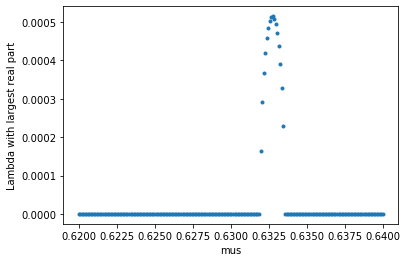

In [148]:
# testing the stability
M = 10;

muMin = 0.62
muMax = 0.64
Nmus =200

mus = np.linspace(muMin, muMax, Nmus)
Ls=np.zeros([1,Nmus],dtype=complex) # vector for eigenvalues
Vs=np.zeros([(2*M)+1,Nmus],dtype=complex) # vector for eigencvectors
maxLamb = np.zeros((Nmus,1)) # vector for eignevalues with largest Real part for every mu


nMu = 0
for mumu in mus: # iterate through mus
    
    lambs,vecsl = gammaFunc(V, phi, phix, mumu, M, spacex, thirdAlpha, fifthBeta, nonlinSigma, soln,'S') # obtain all eigenvalues and eigenvectors
    maxLamb[nMu]=np.max(lambs.real) # pick the largest 
    Ind=np.argwhere(lambs.real==np.max(lambs.real)) # index defined so that we can pick the corresponding eigenvalue and eigenvector
    Ls[0,nMu]=lambs[Ind]
    
    Vs[:,nMu]=vecsl[:,Ind].transpose()
    nMu = nMu+1

    
#plotting the real part of the eigenvalues versus the mu values to see if there is an instability
plt.plot(mus,maxLamb,'.')
plt.xlabel('mus')
plt.ylabel('Lambda with largest real part')

In [141]:
L1

(0.00049353702417489001-0.22806277273722575j)

In [142]:
data=maxLamb

(0.3255, 0.5)

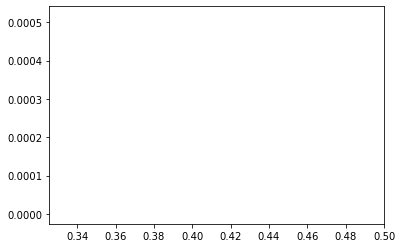

In [143]:
plt.plot(mus,data,'.')
plt.xlim(0.3255,0.5)

## Test for Kawaharainitial <br>

In this test we recreate the bifurcation branch

Text(0, 0.5, 'amplitude')

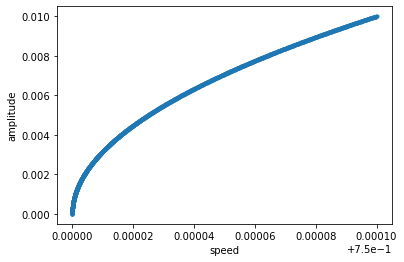

In [144]:

### a1 vs. v ###

plt.plot(velocities,aS,'.')

# plt.xlim([0.756,0.7575]) #zoom
# plt.ylim([0.15,0.19])



# plt.xlim([0.750,0.9])
# plt.ylim([0.,0.02])
# plt.ylim([0.0,0.51])
# plt.xlim([0.960,1.08])
plt.xlabel('speed')
plt.ylabel('amplitude')

In [145]:
### for perturbation testing we will test two mus, the first index is unstable and the second stable

L1=Ls[0,0] # unstable
L2=Ls[0,1] # stable
mu1=mus[0] # unstable
mu2=mus[1] # stable 
vec1=Vs[:,0] # unstable eigenvector
vec2=Vs[:,1] # stable eigenvector
Coeffs=soln

### Storing variables to pass over to the solver ###
%store L1
%store L2
%store mu1
%store mu2
%store vec1
%store vec2
%store soln
%store V
%store M
%store Coeffs

Stored 'L1' (complex128)
Stored 'L2' (complex128)
Stored 'mu1' (float64)
Stored 'mu2' (float64)
Stored 'vec1' (ndarray)
Stored 'vec2' (ndarray)
Stored 'soln' (ndarray)
Stored 'V' (float64)
Stored 'M' (int)
Stored 'Coeffs' (ndarray)


In [146]:
L1

(0.000469939788617987-0.22816256896277654j)